# SN 2022abik 2022-12-1415

### Observing Notes

Another round 30 60-second exposures each in g', r', and i', this time, proceeding across series rather than doing all of g' first.

TheSkyX crashed when approximately 80 of the planned 90 images had been taken.

### Calibration Photos

The calibration photos are in 2022-11-3001.

The bias photos should be discarded in favor of the 1-second (and 30-second) darks. It turns out TheSkyX ignores the exposure time
set on bias photos and does some very rapid exposure. I would not have noticed this if I had not needed some 30-second
bias files.

The 30-second darks were needed because the i' flats required 30 seconds to get a reasonable value.

The i' images are not analyzed below.

In [1]:
import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection, Combiner, combine, subtract_dark, flat_correct
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Log Stretch Utility

from math import log10, floor

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        if pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn


In [3]:
# for an analyses of an observation run done with only a single filter,
# only the observation_date and the exposure times
# will need to be changed

observation_date = '2022-12-1415'
calibration_date = '2022-11-3001'
light_exposure = 60 * u.second
dark_exposure = light_exposure  # our method presumes this equality
flat_exposure = 1 * u.second
bias_exposure = flat_exposure  # our method presumes this equality

In [4]:
# directories where the observation and calibration photos being analyzed are kept

observation_directory = os.path.join(os.path.expanduser('~'), 'Transients', observation_date)
calibration_directory = os.path.join(os.path.expanduser('~'), 'Transients', calibration_date)

In [5]:
# subdirectories -- relative to observation and calibration directories

g_light_directory = os.path.join(observation_directory, 'g')
r_light_directory = os.path.join(observation_directory, 'r')

# the 60-second darks
dark_directory = os.path.join(calibration_directory, 'dark')

# the 1-second g and r flats
g_flat_directory = os.path.join(calibration_directory, 'flat', 'g')
r_flat_directory = os.path.join(calibration_directory, 'flat', 'r')

# the 1-second darks/biases
bias_directory = os.path.join(calibration_directory, 'bias')

g_light_files = ImageFileCollection(g_light_directory).files_filtered(include_path='True')
r_light_files = ImageFileCollection(r_light_directory).files_filtered(include_path='True')
dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')
g_flat_files = ImageFileCollection(g_flat_directory).files_filtered(include_path='True')
r_flat_files = ImageFileCollection(r_flat_directory).files_filtered(include_path='True')
bias_files = ImageFileCollection(bias_directory).files_filtered(include_path='True')


g_lights = [CCDData.read(file, unit=u.adu) for file in g_light_files]
r_lights = [CCDData.read(file, unit=u.adu) for file in r_light_files]
darks = [CCDData.read(file, unit=u.adu) for file in dark_files]
g_flats = [CCDData.read(file, unit=u.adu) for file in g_flat_files]
r_flats = [CCDData.read(file, unit=u.adu) for file in r_flat_files]
biases = [CCDData.read(file, unit=u.adu) for file in bias_files]

# the aligned directories are written to not read from
g_aligned_directory = os.path.join(g_light_directory, 'aligned')
r_aligned_directory = os.path.join(r_light_directory, 'aligned')

if not os.path.exists(g_aligned_directory):
    os.makedirs(g_aligned_directory)
    
if not os.path.exists(r_aligned_directory):
    os.makedirs(r_aligned_directory)

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


### Visualization

In [6]:
sample_image = g_lights[0]

Per the [CCDData documentation](https://docs.astropy.org/en/stable/api/astropy.nddata.CCDData.html)
we should get the data out of the CCDData file as follows:

In [7]:
sample_data = np.asarray(sample_image)

#### Median Subtraction

In [8]:
medians = np.median(sample_data, axis=1, keepdims=True)
subtracted = sample_data - medians

#### Log Stretch

In [9]:
stretch_function = log_stretch_transform(7, 300)
transform = np.vectorize(stretch_function)
transformed = transform(subtracted)

#### Display

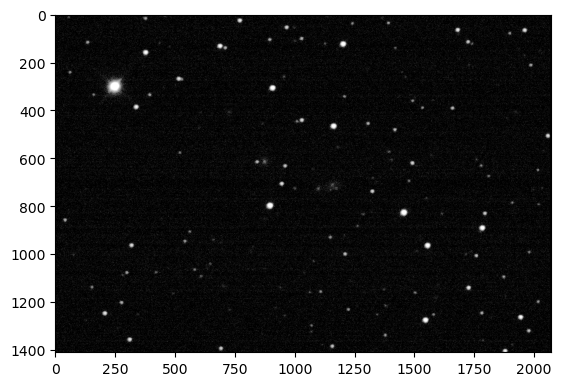

In [10]:
plt.imshow(transformed, cmap='gray')